In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt

from scipy.special import softmax


from obp.ope import (
    # OffPolicyEvaluation,
    RegressionModel,
    # InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    # DoublyRobust as DR,
    # SelfNormalizedDoublyRobust as SNDR
)

from my_utils import (
    eval_policy,
    generate_dataset,
    create_simluation_data_from_pi,
    get_train_data,
    NeighborhoodModel
)
random_state=12345
random_ = check_random_state(random_state)

In [2]:
def calc_reward(dataset, policy):
    return np.array([np.sum(dataset['q_x_a'] * policy.squeeze(), axis=1).mean()])

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
def get_ope_results_dict(reg_results, conv_results):
    reward = conv_results[:, 0]
    return dict(
                policy_rewards=reward.mean(),
                ipw=np.mean(abs(conv_results[: ,3] - reward)),
                reg_dm=np.mean(abs(reg_results - reward)),
                conv_dm=np.mean(abs(conv_results[: ,1] - reward)),
                conv_dr=np.mean(abs(conv_results[: ,2] - reward)),
                conv_sndr=np.mean(abs(conv_results[: ,4] - reward)),
                
                ipw_p_err=np.mean(abs(conv_results[: ,3] - reward) / reward) * 100,
                reg_dm_p_err=np.mean(abs(reg_results - reward) / reward) * 100,
                conv_dm_p_err=np.mean(abs(conv_results[: ,1] - reward) / reward) * 100,
                conv_dr_p_err=np.mean(abs(conv_results[: ,2] - reward) / reward) * 100,
                conv_sndr_p_err=np.mean(abs(conv_results[: ,4] - reward) / reward) * 100,
                
                ipw_var=np.std(conv_results[: ,3]),
                reg_dm_var=np.std(reg_results),
                conv_dm_var=np.std(conv_results[: ,1]),
                conv_dr_var=np.std(conv_results[: ,2]),
                conv_sndr_var=np.std(conv_results[: ,4]),
                )

In [5]:
def plot_results(df):
    fig, ax = plt.subplots(figsize=(10, 5))
    for val in ["ipw", "reg_dm", "conv_dm", "conv_dr", "conv_sndr"]:
        ci = df[val + '_var']
        ax.plot(df.index, df[val], label=val)
        ax.fill_between(df.index, (df[val]-ci), (df[val]+ci), alpha=.1, linestyle='--')


    plt.xlabel("Number of training data")
    plt.ylabel("Policy value error")
    plt.title("IPW vs DM vs DR vs SNDR Errors")
    plt.legend()
    plt.show()
    plt.clf()
    
    df.plot(
    y=["ipw_p_err", "reg_dm_p_err", "conv_dm_p_err", "conv_dr_p_err", "conv_sndr_p_err"],
    title="IPW vs DM vs DR vs SNDR Errors in percentage",
    xlabel="Number of training data",
    figsize=(10, 5),
    marker="o",
    )
    plt.show()
    plt.clf()

In [6]:
result_path = Path(f"./result/{datetime.now().strftime('%Y-%m-%d')}/train_data")
result_path.mkdir(parents=True, exist_ok=True)
result_file_name = f"result_{datetime.now().strftime('%H:00')}.csv"
curve_file_name = f"curve_{datetime.now().strftime('%H:00')}.csv"
print(result_file_name)

result_15:00.csv


## OPE

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

In [7]:
def no_learning_trial(
                      num_runs, 
                      num_neighbors, 
                      num_rounds_list, 
                      dataset
                      ):
    results = {}
    dm = DM()
    our_x, our_a, n_actions = dataset["our_x"], dataset["our_a"], dataset["n_actions"]

    for train_size in num_rounds_list:
        reg_results, conv_results = [], []
        for run in range(num_runs):
            
            greedy = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            pi_0 = softmax(our_x @ our_a.T, axis=1)

            pi_0 = 0.8 * pi_0 + 0.2 * greedy
            simulation_data = create_simluation_data_from_pi(
                                                            pi_0,
                                                            dataset["q_x_a"],
                                                            dataset["n_users"],
                                                            dataset["n_actions"],
                                                            random_state=train_size*(run+1)
                                                            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            
            original_policy_prob = np.expand_dims(pi_0, -1)
            regression_model.fit(train_data['x'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx'], train_data['a']].squeeze())
            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[train_data['x_idx']], regression_model.predict(train_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(eval_policy(neighberhoodmodel, train_data, original_policy_prob[train_data['x_idx']], policy))
            conv_results[-1] = np.append(calc_reward(dataset, policy), conv_results[-1])

        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = get_ope_results_dict(reg_results, conv_results)
        
    return pd.DataFrame.from_dict(results, orient='index')

In [8]:
n_test_data = 5

dataset_params = dict(
                    n_actions= 150,
                    n_users = 150,
                    emb_dim = 5,
                    # sigma = 0.1,
                    eps = 0.2
                    )

dataset = generate_dataset(dataset_params)

# num_rounds_list = [3]
num_rounds_list = [1, 2, 3, 4, 5, 10, 20]

# num_runs = 5 # number of simulations
max_iter = 25 # number of epochs

In [9]:
# dm = DM()
# results = {}
num_runs = 10
batch_size = 50
num_neighbors = 6
# num_rounds_list = [3, 5]

We start with the parameters:
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$
and we run 10 trials for stability and variance calculation


To test the policy $\pi$
We will use an initial policy : $$\pi_{start} = (1-\epsilon)*\pi + \epsilon * greedy$$ to sample examples from the data
and then use ope tools and the convolution model to calculate $\hat{R}$

#### Initial Noised Policy
This is the first policy we will test out, the policy is:

$$emb = 0.8 * gt + 0.2 * noise$$

In [10]:
df1 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, dataset)

In [11]:
df1

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1872,0.0353,0.0266,0.0242,0.0266,0.0345,18.8350,14.1998,12.9072,14.2127,18.4044,0.0354,0.0322,0.0330,0.0336,0.0385
2,0.1872,0.0217,0.0118,0.0114,0.0147,0.0221,11.5673,6.2909,6.1030,7.8590,11.8074,0.0265,0.0148,0.0141,0.0143,0.0215
3,0.1872,0.0244,0.0192,0.0116,0.0151,0.0223,13.0434,10.2567,6.1852,8.0508,11.9360,0.0262,0.0164,0.0130,0.0152,0.0228
4,0.1872,0.0146,0.0193,0.0140,0.0142,0.0145,7.8232,10.3159,7.4896,7.5751,7.7466,0.0189,0.0187,0.0164,0.0174,0.0196
5,0.1872,0.0219,0.0133,0.0154,0.0164,0.0207,11.6860,7.0805,8.2088,8.7413,11.0358,0.0212,0.0145,0.0156,0.0168,0.0209
10,0.1872,0.0140,0.0076,0.0085,0.0094,0.0118,7.4781,4.0417,4.5175,5.0278,6.3183,0.0168,0.0069,0.0105,0.0112,0.0136
20,0.1872,0.0100,0.0104,0.0075,0.0065,0.0056,5.3347,5.5365,4.0168,3.4681,2.9985,0.0111,0.0067,0.0084,0.0077,0.0072


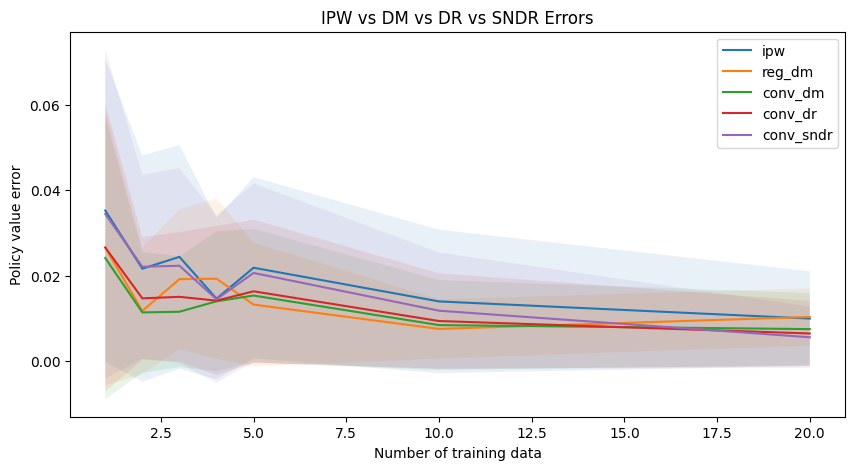

<Figure size 640x480 with 0 Axes>

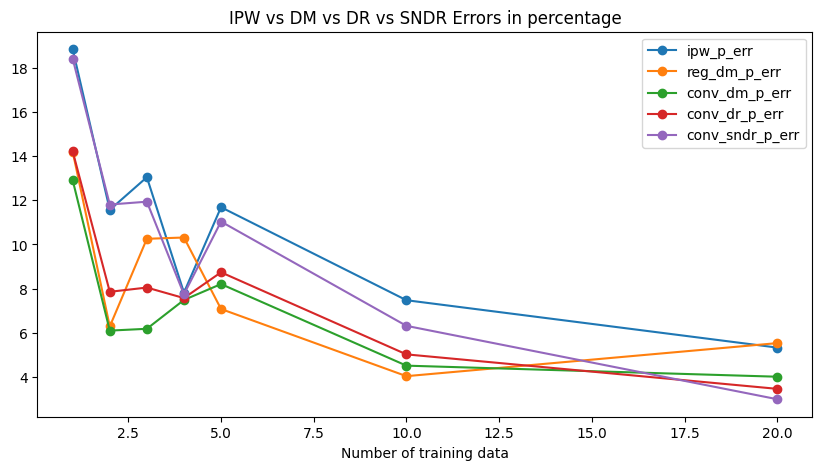

<Figure size 640x480 with 0 Axes>

In [12]:
plot_results(df1)

#### Optimal policy

$$emb = gt

In [13]:
temp_data = dataset.copy()
temp_data['our_a'] = dataset["emb_a"]
temp_data['our_x'] = dataset["emb_x"]

In [14]:
df2 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [15]:
df2

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1940,0.0411,0.0296,0.0262,0.0327,0.0451,21.1555,15.2460,13.4769,16.8303,23.2599,0.0548,0.0344,0.0364,0.0440,0.0557
2,0.1940,0.0319,0.0109,0.0169,0.0192,0.0222,16.4564,5.6155,8.7052,9.9057,11.4280,0.0381,0.0130,0.0197,0.0231,0.0284
3,0.1940,0.0221,0.0160,0.0153,0.0184,0.0227,11.3880,8.2663,7.8880,9.4853,11.7087,0.0263,0.0152,0.0175,0.0196,0.0250
4,0.1940,0.0221,0.0186,0.0152,0.0173,0.0203,11.3675,9.5898,7.8230,8.9246,10.4616,0.0292,0.0191,0.0197,0.0222,0.0256
5,0.1940,0.0174,0.0136,0.0154,0.0151,0.0165,8.9556,7.0279,7.9528,7.7855,8.5283,0.0197,0.0153,0.0190,0.0188,0.0200
10,0.1940,0.0138,0.0083,0.0115,0.0114,0.0117,7.1272,4.2695,5.9106,5.8685,6.0450,0.0142,0.0076,0.0122,0.0119,0.0121
20,0.1940,0.0089,0.0111,0.0066,0.0060,0.0063,4.5777,5.6995,3.4119,3.1068,3.2440,0.0098,0.0070,0.0080,0.0075,0.0075


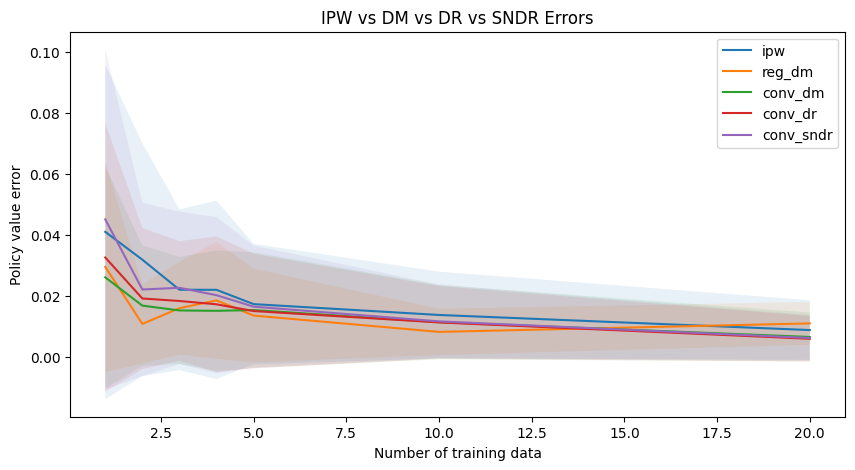

<Figure size 640x480 with 0 Axes>

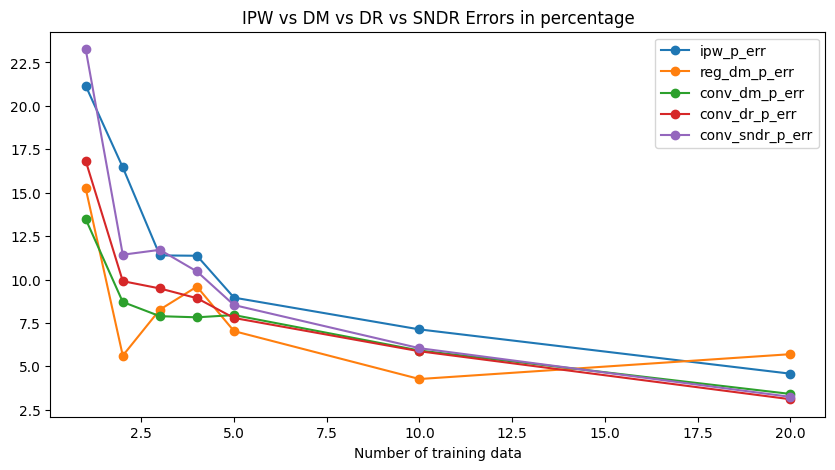

<Figure size 640x480 with 0 Axes>

In [16]:
plot_results(df2)

#### Random Policy

$$emb = noise$$

In [17]:
new_x = random_.normal(size=(dataset_params["n_users"], dataset_params["emb_dim"]))
new_a = random_.normal(size=(dataset_params["n_actions"], dataset_params["emb_dim"]))

temp_data['our_a'] = new_a
temp_data['our_x'] = new_x

In [18]:
df3 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [19]:
df3

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1469,0.0456,0.0253,0.0294,0.0362,0.0436,31.0535,17.2190,20.0446,24.6327,29.6641,0.0464,0.0326,0.0343,0.0401,0.0478
2,0.1469,0.0309,0.0119,0.0200,0.0231,0.0267,21.0171,8.1027,13.6467,15.7385,18.1804,0.0215,0.0119,0.0124,0.0114,0.0140
3,0.1469,0.0216,0.0138,0.0177,0.0188,0.0202,14.6856,9.3754,12.0367,12.7711,13.7736,0.0260,0.0168,0.0198,0.0215,0.0241
4,0.1469,0.0167,0.0113,0.0145,0.0121,0.0103,11.3766,7.6970,9.8428,8.2593,7.0390,0.0207,0.0129,0.0167,0.0149,0.0138
5,0.1469,0.0202,0.0096,0.0117,0.0118,0.0139,13.7655,6.5133,7.9655,8.0319,9.4340,0.0225,0.0113,0.0138,0.0153,0.0179
10,0.1469,0.0124,0.0066,0.0082,0.0098,0.0118,8.4575,4.4849,5.5558,6.6878,8.0277,0.0141,0.0082,0.0096,0.0114,0.0137
20,0.1469,0.0073,0.0046,0.0056,0.0045,0.0067,4.9734,3.1250,3.7852,3.0910,4.5770,0.0080,0.0058,0.0054,0.0053,0.0074


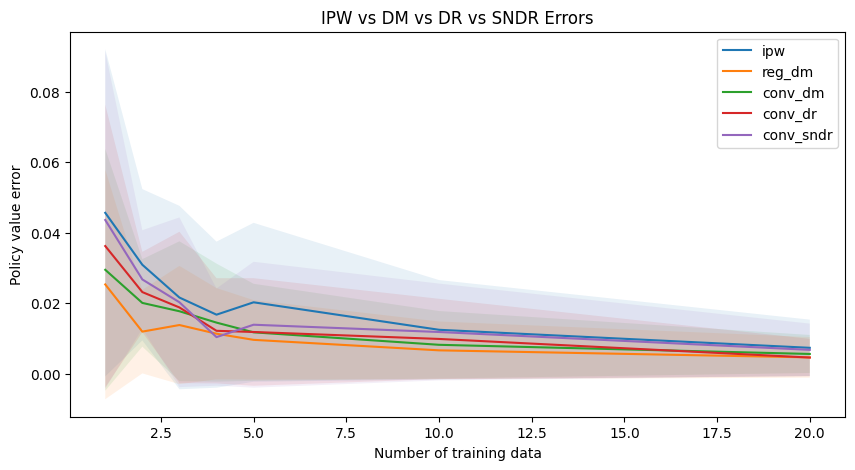

<Figure size 640x480 with 0 Axes>

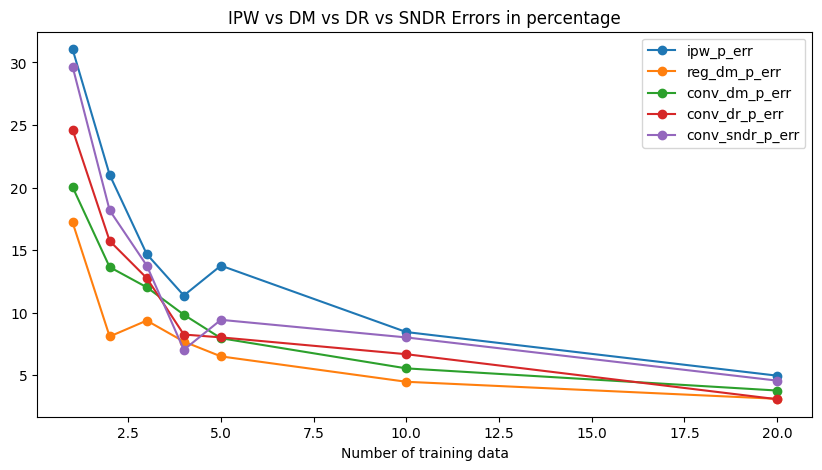

<Figure size 640x480 with 0 Axes>

In [20]:
plot_results(df3)

#### Iterative improvement
At each iteration the model embeddings get closer to the ground truth - $$emb = (1-\epsilon_t) * gt + \epsilon_t * noise$$

In [21]:
df_iterative_improvment = df3.iloc[5:].copy()
df_iterative_improvment['noise level'] = 10

for i in range(1, 11):
    temp_data['our_a'] = ((10-i) * new_a + i * dataset["emb_a"]) /10
    temp_data['our_x'] = ((10-i) * new_x + i * dataset["emb_x"]) /10

    rounds = [num_rounds_list[-1]]
    df = no_learning_trial(num_runs, num_neighbors, rounds, temp_data)
    df['noise level'] = 10 - i
    df_iterative_improvment = pd.concat([df_iterative_improvment, df])

In [22]:
keys_for_display = ['noise level', 'policy_rewards', 
                    'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr',
                    'ipw_var', 'reg_dm_var', 'conv_dm_var', 'conv_dr_var', 'conv_sndr_var']

In [23]:
df_iterative_improvment.iloc[1:][keys_for_display[1:]]

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
20,0.1469,0.0073,0.0046,0.0056,0.0045,0.0067,0.0080,0.0058,0.0054,0.0053,0.0074
20,0.1473,0.0083,0.0049,0.0066,0.0052,0.0080,0.0087,0.0058,0.0074,0.0061,0.0079
20,0.1496,0.0075,0.0055,0.0054,0.0062,0.0083,0.0090,0.0066,0.0073,0.0082,0.0103
20,0.1542,0.0059,0.0071,0.0065,0.0063,0.0061,0.0071,0.0074,0.0082,0.0076,0.0073
20,0.1607,0.0081,0.0075,0.0044,0.0040,0.0047,0.0072,0.0066,0.0063,0.0061,0.0065
20,0.1682,0.0100,0.0071,0.0046,0.0045,0.0058,0.0089,0.0059,0.0064,0.0060,0.0061
20,0.1756,0.0157,0.0072,0.0073,0.0077,0.0084,0.0132,0.0059,0.0090,0.0094,0.0103
20,0.1823,0.0121,0.0098,0.0060,0.0054,0.0070,0.0088,0.0066,0.0082,0.0078,0.0085
20,0.1877,0.0134,0.0104,0.0071,0.0065,0.0058,0.0103,0.0071,0.0086,0.0074,0.0060
20,0.1915,0.0100,0.0108,0.0065,0.0064,0.0072,0.0101,0.0069,0.0075,0.0071,0.0082


In [24]:
df_iterative_improvment.set_index('noise level', inplace=True)

<Axes: title={'center': 'IPW vs DM vs DR vs SNDR Errors'}, xlabel='noise level'>

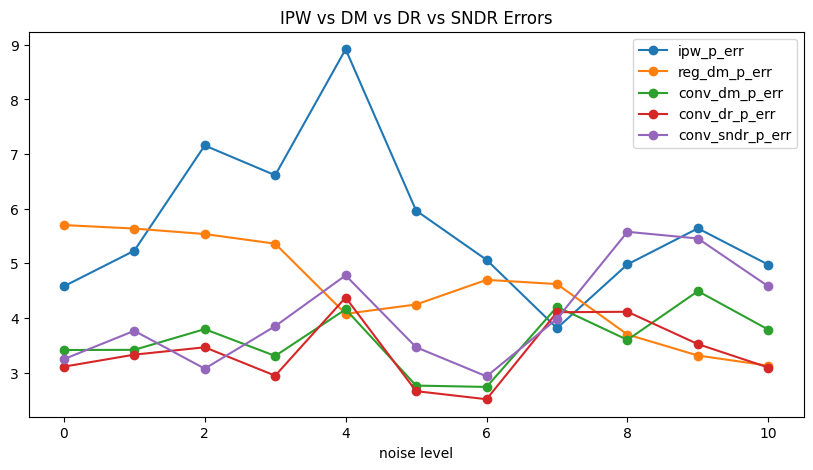

In [25]:
df_iterative_improvment.iloc[1:].plot(
    y=["ipw_p_err",	"reg_dm_p_err",	"conv_dm_p_err", "conv_dr_p_err", "conv_sndr_p_err"],
    title="IPW vs DM vs DR vs SNDR Errors",
    figsize=(10, 5),
    marker="o",
)